<a href="https://colab.research.google.com/github/cuauhtemocbe/Diplomado-Ciencia-Datos/blob/main/notebooks/Practica_3_Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# instlando varclushi, por que lo necesita la biblioteca data_analysis_octopus
!pip install varclushi
!pip install phik
!pip install yellowbrick
# Descargando biblbioteca para análisis de datos
!wget https://raw.githubusercontent.com/cuauhtemocbe/Diplomado-Ciencia-Datos/main/src/data_analysis_octopus.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 4.5 MB/s eta 0:00:00
--2024-08-29 22:37:06--  https://raw.githubusercontent.com/cuauhtemocbe/Diplomado-Ciencia-Datos/main/src/data_analysis_octopus.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34611 (34K) [text/plain]
Saving to: ‘data_analysis_octopus.py’

data_analysis_octop 100%[===================>]  33.80K  --.-KB/s    in 0.01s   

2024-08-29 22:37:06 (3.16 MB/s) - ‘data_analysis_octopus.py’ saved [34611/34611]



## Librerias

In [ ]:
from collections import Counter
from datetime import datetime

import data_analysis_octopus as dao
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.io as pio
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import jaccard
from sklearn import set_config
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.manifold import TSNE
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score,
                             jaccard_score, pairwise_distances,
                             silhouette_score)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


def graficar_hist(df,Var_Continua):
      for column in Var_Continua:
        fig = go.Figure(data=[go.Histogram(x=df[column], histnorm="density")])
        fig.update_layout(title_text=f"Histograma para {column}")
        fig.show()
      return


def graficar_barras(df, Var_Discreta):
      for column in Var_Discreta:
            plt.figure(figsize=(8, 6))
            df[column].value_counts().plot(kind="bar", color="green")
            plt.title(f"Gráfico de barras para {column}")
            plt.xlabel(column)
            plt.xticks(rotation=45)
      return plt.show()


def puntos(data: pd.DataFrame, columnas: list) -> None:
    """
    Genera un gráfico de puntos para todos los pares ordenados de las columnas especificadas de un DataFrame,
    exceptuando los pares cuyos atributos sean el mismo.

    Parámetros:
    data (pd.DataFrame): El DataFrame que contiene los datos.
    columnas (list): Una lista de nombres de columnas continuas para las cuales se generarán los gráficos.

    Retorna:
    Visualiza el gráfico de cada par ordenado argum
    """
    for column_a in columnas:
        for column_b in columnas:
            if column_a == column_b:
              continue
            fig, axs = plt.subplots(1, 1, figsize=(15, 5))
            sns.scatterplot(data=data, x= column_a, y= column_b)
            plt.tight_layout()
            plt.show()


def find_optimal_clusters(data, k_range=(2, 10), metric="distortion", random_state=0):
    """
    Encuentra el número óptimo de clusters utilizando el método del codo con Yellowbrick.

    Parameters:
    data (DataFrame): Conjunto de datos.
    k_range (tuple): Rango de valores de k para probar (default es (2, 10)).
    metric (str): Métrica para el codo ("distortion", "silhouette", "calinski_harabasz").

    Returns:
    int: El número óptimo de clusters.
    """
    # Inicializar el modelo KMeans
    model = KMeans(n_init="auto", random_state=random_state)

    # Inicializar el visualizador de codo con la métrica seleccionada
    visualizer = KElbowVisualizer(model, k=k_range, metric=metric)

    # Ajustar el visualizador a los datos
    visualizer.fit(data)

    # Mostrar el gráfico del codo
    visualizer.show()

    # Retornar el número óptimo de clusters
    return visualizer.elbow_value_


def analyze_clusters(data, numerical_features):
    results = []

    for feat in numerical_features:
        grouped = data.groupby("cluster")[feat].apply(list)
        f_stat, p_value = stats.f_oneway(*grouped)

        label = "Son similares"
        groups_different = []

        if p_value < 0.05:
            label = "Son significativamente diferentes"
            # Tukey
            tukey = pairwise_tukeyhsd(endog=data[feat], groups=data["cluster"], alpha=0.05)
            summary = tukey.summary()
            summary_list = [line.split() for line in summary.as_text().split("\n") if line.strip()]
            tukey_df = pd.DataFrame(summary_list[4:-1], columns=summary_list[2])
            significant_comparisons = tukey_df[tukey_df["reject"] == "True"]

            for _, row in significant_comparisons.iterrows():
                groups_different.append((row["group1"], row["group2"]))

        results.append(
            {
                "Característica": feat,
                "f_stat": round(f_stat, 0),
                "p_value": round(p_value, 4),
                "Etiqueta": label,
                "Grupos que son diferentes": groups_different
            })

    results_df = pd.DataFrame(results)

    return results_df


def count_significant_pairs(data):
    # Filtrar las características con diferencias significativas
    filtered_df = data[data["Etiqueta"] == "Son significativamente diferentes"]

    # Obtener la lista de pares de grupos que son diferentes
    list_of_lists = filtered_df["Grupos que son diferentes"].tolist()

    # Aplanar la lista de listas
    flattened_list = [pair for sublist in list_of_lists for pair in sublist]

    # Contar la ocurrencia de cada par
    pair_counts = Counter(flattened_list)

    # Crear DataFrame con los resultados y ordenar por el conteo
    pair_counts_df = pd.DataFrame(pair_counts.items(), columns=["Par", "Conteo"]).sort_values("Conteo", ascending=False)

    return pair_counts_df


def agrupaLimites(df,column,liminf,limsup):
    df.loc[(df[column] <= liminf), column] = liminf
    df.loc[(df[column] >= limsup), column] = limsup
    return df


def count_nulls(data):
    """
    Counts the number of null values per column in a DataFrame.

    Args:
        data (pd.DataFrame): The DataFrame to analyze.

    Returns:
        pd.Series: Series with the count of null values per column, only for columns that have null values.
    """
    nulls_per_column = data.isnull().sum()
    nulls_per_column = nulls_per_column[nulls_per_column > 0]
    return nulls_per_column

def score_plot(scores, range_n_clusters, operator, name_index):
    # Encontrar el número de conglomerados con la mejor puntuación
    clusters = list(range_n_clusters)

    if operator == 'max':
        operator = max(scores)
    elif operator == 'min':
        operator = min(scores)

    best_index = clusters[scores.index(operator)]
    best_score = max(scores)

    # Crear el gráfico de líneas para las puntuaciones
    fig = go.Figure()

    # Añadir la línea de puntuación
    fig.add_trace(go.Scatter(x=clusters, y=scores, mode='lines+markers', name=name_index))

    # Añade una línea de puntos para la mejor puntuación
    fig.add_trace(go.Scatter(x=[best_index, best_index], y=[0, best_score], mode='lines', name='Mejor Índice',
                            line=dict(color='red', width=2, dash='dot')))

    # Actualizar layout
    fig.update_layout(height=500, width=1200, title_text="",
                    xaxis_title='Número de Clusters',
                    yaxis_title=name_index,
                    showlegend=True)
    fig.show()

In [ ]:
random_seed = 333  # Semilla para reproducibilidad de resultados
np.random.seed(random_seed)  # Para reproducibilidad
# Configuración de opciones de visualización para pandas
pd.set_option("display.max_columns", None)  # Muestra todas las columnas
pd.set_option("display.max_rows", 20)  # Ajusta el número de filas a mostrar

# Configuraciones extras
sns.set_style("dark")
dark_template = pio.templates["plotly_dark"].to_plotly_json()
dark_template["layout"]["paper_bgcolor"] = "rgba(30, 30, 30, 0.5)"
dark_template["layout"]["plot_bgcolor"] = "rgba(30, 30, 30, 0)"
pio.templates["plotly_dark_semi_transparent"] = go.layout.Template(dark_template)
pio.templates.default = "plotly_dark_semi_transparent"
set_config(transform_output="pandas")
set_config(display="diagram")

%matplotlib inline

**Sobre los datos**

El conjunto de datos AIRBNB-NY corresponde a datos de alojamientos de
Airbnb en Nueva York. Ofrece una visión amplia sobre las caracterısticas de los alojamientos, incluyendo localizacion, tipo de propiedad, número de habitaciones, entre otras.

El **objetivo** de analizar este conjunto de datos es identificar patrones de agrupamiento entre los alojamientos, lo que puede ayudar tanto a los anfitriones para mejorar su oferta como a los huéspedes para tomar decisiones informadas.

Conectar con la base de datos

In [ ]:
dict_df = pd.read_csv("https://raw.githubusercontent.com/cuauhtemocbe/Diplomado-Ciencia-Datos/main/data/Airbnb/dictionary_trabajado.csv")
dict_df

Field  Eliminar      Type  \
0                                             id       1.0   integer   
1                                    listing_url       1.0      text   
2                                      scrape_id       1.0    bigint   
3                                   last_scraped       1.0  datetime   
4                                           name       1.0      text   
..                                           ...       ...       ...   
69                calculated_host_listings_count       NaN   integer   
70   calculated_host_listings_count_entire_homes       NaN   integer   
71  calculated_host_listings_count_private_rooms       NaN   integer   
72   calculated_host_listings_count_shared_rooms       NaN   integer   
73                             reviews_per_month       NaN   numeric   

   Calculated                                        Description Reference  
0         NaN         Airbnb's unique identifier for the listing       NaN  
1           y                                                NaN       NaN  
2           y            Inside Airbnb "Scrape" this was part of       NaN  
3           y  UTC. The date and time this listing was "scrap...       NaN  
4         NaN                                Name of the listing       NaN  
..        ...                                                ...       ...  
69          y  The number of listings the host has in the cur...       NaN  
70          y  The number of Entire home/apt listings the hos...       NaN  
71          y  The number of Private room listings the host h...       NaN  
72          y  The number of Shared room listings the host ha...       NaN  
73          y  The number of reviews the listing has over the...       NaN  

[74 rows x 6 columns]

**Un "listing" de Airbnb es un anuncio en línea creado por anfitriones para mostrar su propiedad en la plataforma de Airbnb. Sirve como una representación digital del alojamiento, proporcionando detalles esenciales y elementos visuales atractivos para atraer huéspedes potenciales.**

In [ ]:
raw_df = pd.read_csv("https://raw.githubusercontent.com/cuauhtemocbe/Diplomado-Ciencia-Datos/main/data/Airbnb/listings.csv")
raw_df = raw_df.set_index("id")
raw_df.head(3)

<ipython-input-5-1608146a537b>:1: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("https://raw.githubusercontent.com/cuauhtemocbe/Diplomado-Ciencia-Datos/main/data/Airbnb/listings.csv")


listing_url       scrape_id last_scraped  \
id                                                                     
2595  https://www.airbnb.com/rooms/2595  20211204143024   2021-12-05   
3831  https://www.airbnb.com/rooms/3831  20211204143024   2021-12-05   
5121  https://www.airbnb.com/rooms/5121  20211204143024   2021-12-05   

                                                   name  \
id                                                        
2595                              Skylit Midtown Castle   
3831  Whole flr w/private bdrm, bath & kitchen(pls r...   
5121                                    BlissArtsSpace!   

                                            description  \
id                                                        
2595  Beautiful, spacious skylit studio in the heart...   
3831  Enjoy 500 s.f. top floor in 1899 brownstone, w...   
5121  <b>The space</b><br />HELLO EVERYONE AND THANK...   

                                  neighborhood_overview  \
id                                                        
2595  Centrally located in the heart of Manhattan ju...   
3831  Just the right mix of urban center and local n...   
5121                                                NaN   

                                            picture_url  host_id  \
id                                                                 
2595  https://a0.muscache.com/pictures/f0813a11-40b2...     2845   
3831  https://a0.muscache.com/pictures/e49999c2-9fd5...     4869   
5121  https://a0.muscache.com/pictures/2090980c-b68e...     7356   

                                    host_url    host_name  host_since  \
id                                                                      
2595  https://www.airbnb.com/users/show/2845     Jennifer  2008-09-09   
3831  https://www.airbnb.com/users/show/4869  LisaRoxanne  2008-12-07   
5121  https://www.airbnb.com/users/show/7356        Garon  2009-02-03   

                          host_location  \
id                                        
2595  New York, New York, United States   
3831  New York, New York, United States   
5121  New York, New York, United States   

                                             host_about  host_response_time  \
id                                                                            
2595  A New Yorker since 2000! My passion is creatin...        within a day   
3831  Laid-back Native New Yorker (formerly bi-coast...  a few days or more   
5121   I am an artist(painter, filmmaker) and curato...      within an hour   

     host_response_rate host_acceptance_rate host_is_superhost  \
id                                                               
2595                80%                  17%                 f   
3831                 9%                  69%                 f   
5121               100%                 100%                 f   

                                     host_thumbnail_url  \
id                                                        
2595  https://a0.muscache.com/im/pictures/user/50fc5...   
3831  https://a0.muscache.com/im/users/4869/profile_...   
5121  https://a0.muscache.com/im/pictures/user/72a61...   

                                       host_picture_url  host_neighbourhood  \
id                                                                            
2595  https://a0.muscache.com/im/pictures/user/50fc5...             Midtown   
3831  https://a0.muscache.com/im/users/4869/profile_...        Clinton Hill   
5121  https://a0.muscache.com/im/pictures/user/72a61...  Bedford-Stuyvesant   

      host_listings_count  host_total_listings_count  \
id                                                     
2595                  8.0                        8.0   
3831                  1.0                        1.0   
5121                  1.0                        1.0   

                                     host_verifications host_has_profile_pic  \
id                                                                          

In [ ]:
raw_df.shape

(38277, 73)

## Preprocesamiento
### Eliminando columnas que no aportan información, como: ids, urls, entre otros

In [ ]:
# Seleccionaoms columnas que son innecesarias para el análisis
columns_to_remove = dict_df[dict_df["Eliminar"] == 1]["Field"].to_list()

columns_to_remove += [
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm"
]

columns_to_remove.remove("id")

In [ ]:
print("columnas iniciales", raw_df.shape[1])
df = raw_df.drop(columns=columns_to_remove)
print("columnas finales", df.shape[1])

columnas iniciales 73
columnas finales 45


### Detección y remoción de variables poco pobladas
para valores con cantidad de valores nulos > 30%

In [ ]:
THRESHOLD = 30
completitud_df = dao.DataViz.completitud(df)
remove_features = completitud_df[completitud_df["% valores nulos"] >= THRESHOLD]
if remove_features.empty:
  print(f"No hay variables con valores nulos > {THRESHOLD}%")
else:
  cols_to_remove = remove_features.features.to_list()
  display(remove_features)

features  Total de nulos  % valores nulos
1   neighborhood_overview           15627            40.83
3      host_response_time           17193            44.92
4      host_response_rate           17193            44.92
5    host_acceptance_rate           16486            43.07
16              bathrooms           38277           100.00

In [ ]:
print("columnas iniciales", df.shape[1])
df = df.drop(columns=cols_to_remove)
print("columnas finales", df.shape[1])

columnas iniciales 45
columnas finales 40


### Detección y remoción de variables unitarias
cuando el 90% de la información se agrupe dentro de una sola variable

In [ ]:
THRESHOLD = 90

dfs_list = []
for c in df.columns:
    tmp_count = dao.count_percentage(df, c)

    tmp_df = tmp_count[tmp_count["porcentaje"] >= THRESHOLD]

    if not tmp_df.empty:
        dfs_list.append(dao.create_feature_dataframe(tmp_df, c))

if dfs_list:
    unit_vars = pd.concat(dfs_list).reset_index(drop=True)
    display(unit_vars)
else:
    print("No hay variables unitarias")

feature category  conteo  porcentaje
0                         host_has_profile_pic        t   37994       99.35
1                             has_availability        t   36159       94.47
2  calculated_host_listings_count_shared_rooms        0   37423       97.77

In [ ]:
if not unit_vars.empty:
  print("columnas iniciales", df.shape[1])
  df = df.drop(columns=unit_vars["feature"].to_list())
  print("columnas finales", df.shape[1])

columnas iniciales 40
columnas finales 37


### Detección y remoción de registros con pocos valores
cuando el 70% de la información tenga valores nulos

In [ ]:
# Definir el porcentaje máximo permitido de NaNs (por ejemplo, 50%)
porcentaje_maximo = 0.3

# Calcular el umbral en función del porcentaje
numero_columnas = df.shape[1]
umbral = int((1 - porcentaje_maximo) * numero_columnas)

# Eliminar filas con más del porcentaje máximo de valores NaN
print("Tamaño original: ", df.shape[0])
df = df.dropna(thresh=umbral)
print("Tamaño final: ", df.shape[0])

Tamaño original:  38277
Tamaño final:  38263


### Manejo de columnas especiales

**host_since**

In [ ]:
# Convertir la columna de fechas a datetime
df["host_since"] = pd.to_datetime(df["host_since"])

# Obtener la fecha actual
today = pd.to_datetime(datetime.today().date())
# Calcular la diferencia en días
df.loc[:, "host_since_days"] = (today - df["host_since"]).dt.days

<ipython-input-14-bf0896e7c499>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["host_since"] = pd.to_datetime(df["host_since"])
<ipython-input-14-bf0896e7c499>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "host_since_days"] = (today - df["host_since"]).dt.days


**host_verifications**

Obteniendo el número de verificaciones por listing

In [ ]:
df.loc[:, "host_verifications"] = df["host_verifications"].fillna("")
df.loc[:, "num_host_verifications"] = df["host_verifications"].str.split(",").apply(len)

**amenities**

In [ ]:
df["amenities"] = df["amenities"].fillna("")
df["num_amenities"] = df["amenities"].str.split(",").apply(len)

**price**

In [ ]:
df["price_cleaned"] = df["price"].str.replace("$", "")
df["price_cleaned"] = df["price_cleaned"].str.replace(",", "")
df["price_processed"] = df["price_cleaned"].astype(float)

**bathrooms**

In [ ]:
df["bathrooms_text"] = df["bathrooms_text"].str.lower()
df["bathrooms_text"] = df["bathrooms_text"].fillna("")
df["num_bathrooms"] = df["bathrooms_text"].str.extract(r"(\d+\.?\d*)").astype(float)
df.loc[df["bathrooms_text"].str.contains("half-bath"), "num_bathrooms"] = 0.5

In [ ]:
# Eliminando columnas ya procesadas o temporales
columns_to_remove =[
    "host_since",
    "price",
    "amenities",
    "host_verifications",
    "bathrooms_text",
    "price_cleaned"
]

df = df.drop(columns=columns_to_remove)

**Clasificación de features**

In [ ]:
categorical_features = [
    "room_type", "bedrooms", "beds",
    "num_host_verifications", "num_amenities",
    "neighbourhood_group_cleansed",
    "property_type",
    "instant_bookable",
    "host_identity_verified",
    "host_is_superhost",
    "num_bathrooms",
    "accommodates"
]

numerical_features = [
    "availability_30", "availability_365", "availability_60",
    "availability_90", "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms",
    "host_listings_count",
    "host_since_days", "host_total_listings_count",  "maximum_nights",
    "minimum_nights", "number_of_reviews", "number_of_reviews_l30d",
    "number_of_reviews_ltm","price_processed", "review_scores_accuracy",
    "review_scores_checkin", "review_scores_cleanliness", "review_scores_communication",
    "review_scores_location", "review_scores_rating", "review_scores_value", "reviews_per_month"
]

### Detección y tratamiento de valores ausentes

In [ ]:
for col in numerical_features:
    media = df[col].median()
    df.loc[:, col] = df[col].fillna(media)

for col in categorical_features:
    moda = df[col].mode()[0]
    df.loc[:, col] = df[col].fillna(moda)

count_nulls(df)

description    1192
dtype: int64

### Detección y manejo de valores extremos

In [ ]:
df[numerical_features] = df[numerical_features].astype(float)

iso_forest = IsolationForest(contamination=0.05, random_state=random_seed)
df["is_outlier"] = iso_forest.fit_predict(df[numerical_features])

df.value_counts("is_outlier")

is_outlier
 1    36349
-1     1914
Name: count, dtype: int64

In [ ]:
df.loc[df["is_outlier"] == -1, numerical_features] = np.nan

imputer = KNNImputer(n_neighbors=5)
df[numerical_features] = imputer.fit_transform(df[numerical_features])

df = df.drop(columns="is_outlier")
count_nulls(df)

description    1192
dtype: int64

### Reducción de cardinalidad
Se agruparan en la categoría otros, para los grupos muy pequeños.

In [ ]:
df = agrupaLimites(df,'bedrooms',0,3)
df = agrupaLimites(df,'num_host_verifications',3,8)
df = agrupaLimites(df,'beds',0,3)
df = agrupaLimites(df,'num_amenities',10,19)
df = agrupaLimites(df,'accommodates',1,5)

categorical_threshold_dict = {
    "room_type": 0.2,
    #"bedrooms": 0.15,
    "beds": 0.1,
    #"num_host_verifications": 0.1,
    #"num_amenities": 0.03,
    "neighbourhood_group_cleansed": 0.15,
    "property_type": 0.1,
    "num_bathrooms": 0.1,
    #"accommodates": 0.1
}

for column, threshold in categorical_threshold_dict.items():
  df = dao.reduce_cardinality(df, column, threshold=threshold)

In [ ]:
df.to_pickle("df_backup.pkl")

## Análisis exploratorio

In [ ]:
dao.freq_discrete(df, categorical_features)

Feature: room_type


Absolute frequency Relative frequency Accumulated frequency  \
room_type                                                                     
Entire home/apt             20,385             53.28%                20,385   
Private room                17,096             44.68%                37,481   
Otros                          782              2.04%                38,263   

                Accumulated %  
room_type                      
Entire home/apt        53.28%  
Private room           97.96%  
Otros                 100.00%

Feature: bedrooms


Absolute frequency Relative frequency Accumulated frequency  \
bedrooms                                                               
1.0                  30,494             79.70%                30,494   
2.0                   5,369             14.03%                35,863   
3.0                   2,400              6.27%                38,263   

         Accumulated %  
bedrooms                
1.0             79.70%  
2.0             93.73%  
3.0            100.00%

Feature: beds


Absolute frequency Relative frequency Accumulated frequency Accumulated %
beds                                                                          
1.0              25,530             66.72%                25,530        66.72%
2.0               7,927             20.72%                33,457        87.44%
3.0               4,806             12.56%                38,263       100.00%

Feature: num_host_verifications


Absolute frequency Relative frequency  \
num_host_verifications                                         
3                                   8,687             22.70%   
6                                   7,215             18.86%   
5                                   6,636             17.34%   
4                                   5,767             15.07%   
7                                   5,005             13.08%   
8                                   4,953             12.94%   

                       Accumulated frequency Accumulated %  
num_host_verifications                                      
3                                      8,687        22.70%  
6                                     15,902        41.56%  
5                                     22,538        58.90%  
4                                     28,305        73.97%  
7                                     33,310        87.06%  
8                                     38,263       100.00%

Feature: num_amenities


Absolute frequency Relative frequency Accumulated frequency  \
num_amenities                                                               
19                        21,193             55.39%                21,193   
10                         5,088             13.30%                26,281   
13                         1,660              4.34%                27,941   
15                         1,649              4.31%                29,590   
14                         1,635              4.27%                31,225   
12                         1,523              3.98%                32,748   
16                         1,491              3.90%                34,239   
17                         1,408              3.68%                35,647   
11                         1,384              3.62%                37,031   
18                         1,232              3.22%                38,263   

              Accumulated %  
num_amenities                
19                   55.39%  
10                   68.69%  
13                   73.02%  
15                   77.33%  
14                   81.61%  
12                   85.59%  
16                   89.48%  
17                   93.16%  
11                   96.78%  
18                  100.00%

Feature: neighbourhood_group_cleansed


Absolute frequency Relative frequency  \
neighbourhood_group_cleansed                                         
Manhattan                                16,770             43.83%   
Brooklyn                                 14,713             38.45%   
Otros                                     6,780             17.72%   

                             Accumulated frequency Accumulated %  
neighbourhood_group_cleansed                                      
Manhattan                                   16,770        43.83%  
Brooklyn                                    31,483        82.28%  
Otros                                       38,263       100.00%

Feature: property_type


Absolute frequency Relative frequency  \
property_type                                                       
Entire rental unit                      16,012             41.85%   
Private room in rental unit             11,663             30.48%   
Otros                                   10,588             27.67%   

                            Accumulated frequency Accumulated %  
property_type                                                    
Entire rental unit                         16,012        41.85%  
Private room in rental unit                27,675        72.33%  
Otros                                      38,263       100.00%

Feature: instant_bookable


Absolute frequency Relative frequency Accumulated frequency  \
instant_bookable                                                               
f                            27,847             72.78%                27,847   
t                            10,416             27.22%                38,263   

                 Accumulated %  
instant_bookable                
f                       72.78%  
t                      100.00%

Feature: host_identity_verified


Absolute frequency Relative frequency  \
host_identity_verified                                         
t                                  31,886             83.33%   
f                                   6,377             16.67%   

                       Accumulated frequency Accumulated %  
host_identity_verified                                      
t                                     31,886        83.33%  
f                                     38,263       100.00%

Feature: host_is_superhost


Absolute frequency Relative frequency Accumulated frequency  \
host_is_superhost                                                               
f                             30,885             80.72%                30,885   
t                              7,378             19.28%                38,263   

                  Accumulated %  
host_is_superhost                
f                        80.72%  
t                       100.00%

Feature: num_bathrooms


Absolute frequency Relative frequency Accumulated frequency  \
num_bathrooms                                                               
1.0                       32,047             83.75%                32,047   
Otros                      6,216             16.25%                38,263   

              Accumulated %  
num_bathrooms                
1.0                  83.75%  
Otros               100.00%

Feature: accommodates


Absolute frequency Relative frequency Accumulated frequency  \
accommodates                                                               
2                        17,480             45.68%                17,480   
1                         6,600             17.25%                24,080   
4                         5,857             15.31%                29,937   
5                         4,632             12.11%                34,569   
3                         3,694              9.65%                38,263   

             Accumulated %  
accommodates                
2                   45.68%  
1                   62.93%  
4                   78.24%  
5                   90.35%  
3                  100.00%

In [ ]:
df.describe().round(2)

host_listings_count  host_total_listings_count  accommodates  bedrooms  \
count             38263.00                   38263.00      38263.00  38263.00   
mean                 15.34                      15.34          2.59      1.27   
std                  89.49                      89.49          1.27      0.57   
min                   0.00                       0.00          1.00      1.00   
25%                   1.00                       1.00          2.00      1.00   
50%                   1.00                       1.00          2.00      1.00   
75%                   4.00                       4.00          4.00      1.00   
max                3387.00                    3387.00          5.00      3.00   

           beds  minimum_nights  maximum_nights  availability_30  \
count  38263.00         38263.0    3.826300e+04         38263.00   
mean       1.46            21.2    6.082792e+04             6.55   
std        0.71            26.9    1.097937e+07             9.52   
min        1.00             1.0    1.000000e+00             0.00   
25%        1.00             3.0    6.000000e+01             0.00   
50%        1.00            30.0    1.125000e+03             1.00   
75%        2.00            30.0    1.125000e+03             9.00   
max        3.00          1250.0    2.147484e+09            30.00   

       availability_60  availability_90  availability_365  number_of_reviews  \
count         38263.00         38263.00          38263.00           38263.00   
mean             19.04            32.80            128.82              22.62   
std              21.16            33.62            138.03              45.00   
min               0.00             0.00              0.00               0.00   
25%               0.00             0.00              0.00               1.00   
50%              11.00            29.00             77.00               5.00   
75%              36.00            64.00            273.00              22.62   
max              60.00            90.00            365.00             545.00   

       number_of_reviews_ltm  number_of_reviews_l30d  review_scores_rating  \
count               38263.00                38263.00              38263.00   
mean                    4.42                    0.49                  4.68   
std                     9.86                    1.18                  0.65   
min                     0.00                    0.00                  0.00   
25%                     0.00                    0.00                  4.68   
50%                     0.00                    0.00                  4.82   
75%                     4.42                    0.00                  4.94   
max                   120.00                   14.00                  5.00   

       review_scores_accuracy  review_scores_cleanliness  \
count                38263.00                   38263.00   
mean                     4.83                       4.70   
std                      0.26                       0.37   
min                      0.00                       0.00   
25%                      4.82                       4.67   
50%                      4.90                       4.80   
75%                      5.00                       4.92   
max                      5.00                       5.00   

       review_scores_checkin  review_scores_communication  \
count               38263.00                     38263.00   
mean                    4.89                         4.89   
std                     0.22                         0.22   
min                     0.00                         0.00   
25%                     4.89                         4.89   
50%                     4.96                         4.97   
75%                     5.00                         5.00   
max                     5.00                         5.00   

       review_scores_location  review_scores_value  \
count                38263.00             38263.00   
mean                     4.81            

In [ ]:
graficar_hist(df, numerical_features)

### Heatmap

**Person**

In [ ]:
corr_df = df[numerical_features].corr().round(2) * 100
corr_df = corr_df.fillna(0).astype(int)
dao.heatmap(corr_df)

### Correlación phi-k

In [ ]:
subset = df.columns[df.columns != "description"]

phik_df = df[subset].phik_matrix()
phik_df = phik_df.round(2) * 100

dao.heatmap(phik_df)

interval columns not set, guessing: ['host_listings_count', 'host_total_listings_count', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'reviews_per_month', 'host_since_days', 'num_host_verifications', 'num_amenities', 'price_processed']


O**bservaciones basadas en la matriz de correlaciones:**

**Alta correlación:** Hay ciertas variables que tienen alta correlación, como property_type con room_type o bedrooms con beds.

**Variables con correlaciones bajas:** Algunas variables, como host_is_superhost y host_identity_verified, no están muy correlacionadas con la mayoría de las otras variables. Esto podría indicar que representan características únicas que podrían influir en la agrupación de los alojamientos.

## Clustering con K-means con features seleccionadas
con un enfoque en el lugar



In [ ]:
categorical_features = [
    # "neighbourhood_group_cleansed", "room_type","bedrooms", "beds",
    # "instant_bookable","num_amenities", "num_bathrooms",
    # "accommodates"
    "neighbourhood_group_cleansed", "room_type", "beds",
    "num_amenities",
]

numerical_features = [
    "availability_60", "price_processed",
    "number_of_reviews_ltm",
    "review_scores_rating"
]

encoder = OneHotEncoder(drop="first", sparse_output=False, dtype=int)
encoded_df = encoder.fit_transform(df[categorical_features].astype(str))

scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)

processed_df = pd.concat([encoded_df, scaled_df], axis=1)
processed_df.to_pickle("processed_df.pkl")
print(processed_df.shape)


(38263, 19)


### Score Elbow

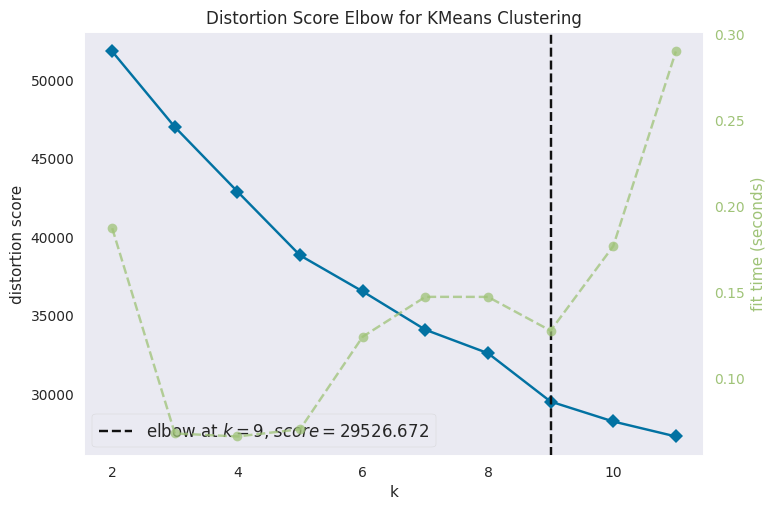

El número óptimo de clusters es: 9


In [ ]:
optimal_k = find_optimal_clusters(processed_df, k_range=(2, 12), metric="distortion", random_state=random_seed)
print(f"El número óptimo de clusters es: {optimal_k}")

### Métrica de Silueta

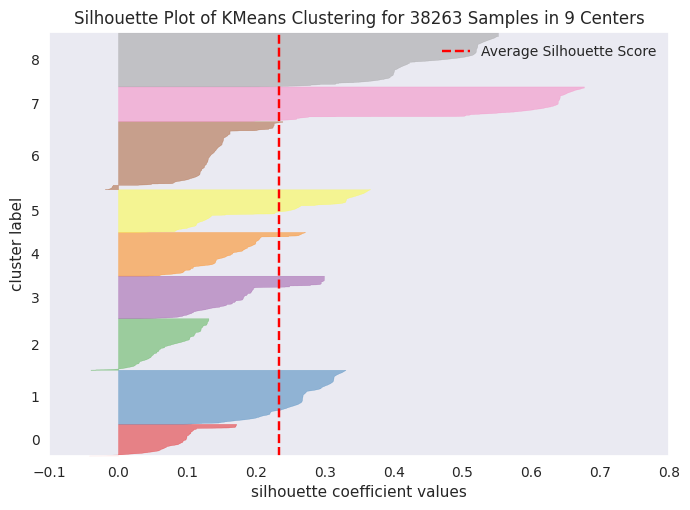

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 38263 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
model = KMeans(n_clusters=optimal_k, n_init="auto", random_state=random_seed)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(processed_df)
visualizer.show()

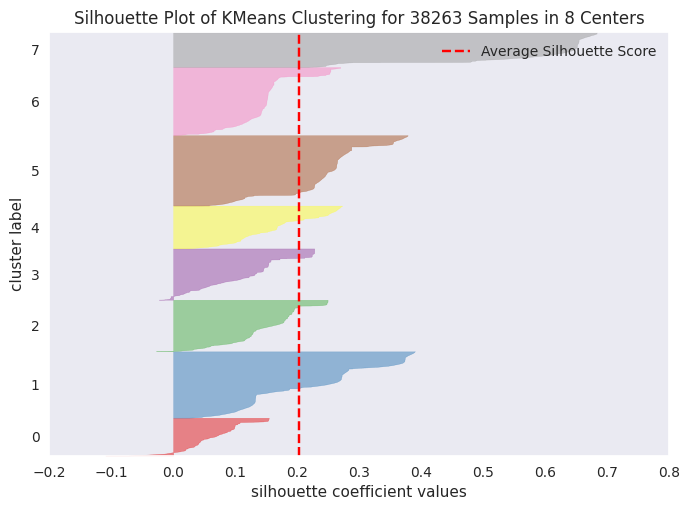

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 38263 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
model = KMeans(n_clusters=optimal_k - 1, n_init="auto", random_state=random_seed)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(processed_df)
visualizer.show()

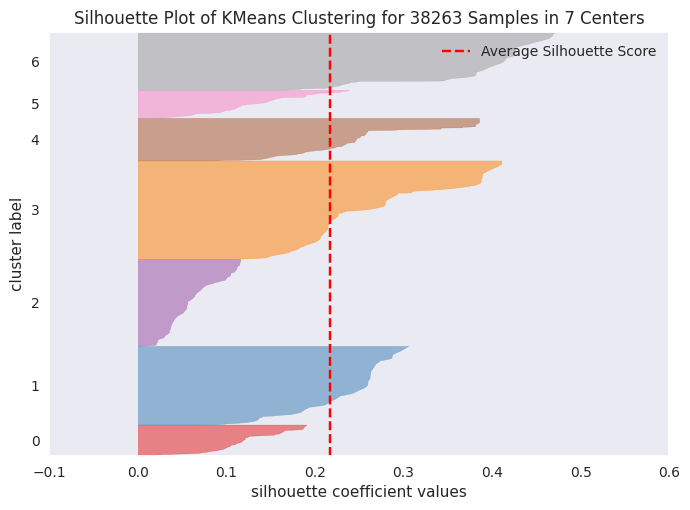

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 38263 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
model = KMeans(n_clusters=optimal_k - 2, n_init="auto", random_state=random_seed)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(processed_df)
visualizer.show()

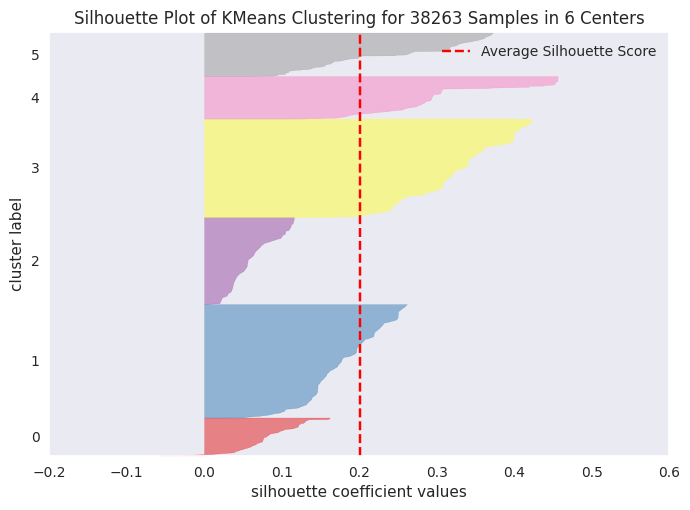

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 38263 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
model = KMeans(n_clusters=optimal_k - 3, n_init="auto", random_state=random_seed)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(processed_df)
visualizer.show()

### Calinski-Harabasz Score y Davies-Bouldin Score

---



---



In [ ]:
davies_bouldin_scores = []; calinski_harabasz_scores = []
range_n_clusters=range(2,optimal_k+1)
for n_clusters in range_n_clusters:
  kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300,random_state=random_seed)
  cluster_labels = kmeans.fit_predict(processed_df)
  davies_bouldin_ = davies_bouldin_score(processed_df, cluster_labels); davies_bouldin_scores.append(davies_bouldin_)
  calinski_harabasz_ = calinski_harabasz_score(processed_df, cluster_labels); calinski_harabasz_scores.append(calinski_harabasz_)

In [ ]:
score_plot(scores=calinski_harabasz_scores, range_n_clusters=range_n_clusters,
         operator='max', name_index = 'Índice de C-H')

In [ ]:
score_plot(scores=davies_bouldin_scores, range_n_clusters=range_n_clusters,
         operator='min', name_index = 'Índice de D-B')

In [ ]:
model = KMeans(n_clusters=6, n_init="auto", random_state=random_seed)
df["cluster"] = model.fit_predict(processed_df)
df.value_counts("cluster", normalize=True)

cluster
1    0.267883
3    0.232444
2    0.205839
5    0.103259
4    0.100515
0    0.090061
Name: proportion, dtype: float64

## ANOVA y Tukey

In [ ]:
filtered_numerical_features = [c for c in df.columns if c in numerical_features]
anova_df = analyze_clusters(df, filtered_numerical_features)
anova_df

Característica  f_stat  p_value                           Etiqueta  \
0        availability_60   340.0      0.0  Son significativamente diferentes   
1  number_of_reviews_ltm   678.0      0.0  Son significativamente diferentes   
2   review_scores_rating   112.0      0.0  Son significativamente diferentes   
3        price_processed   270.0      0.0  Son significativamente diferentes   

                           Grupos que son diferentes  
0  [(0, 1), (0, 2), (0, 3), (0, 5), (1, 2), (1, 4...  
1  [(0, 1), (0, 3), (0, 5), (1, 2), (1, 3), (1, 4...  
2  [(0, 1), (0, 3), (0, 5), (1, 2), (1, 3), (1, 4...  
3  [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2...

In [ ]:
count_significant_pairs(anova_df)

Par  Conteo
0   (0, 1)       4
2   (0, 3)       4
3   (0, 5)       4
4   (1, 2)       4
5   (1, 4)       4
6   (1, 5)       4
7   (2, 3)       4
9   (2, 5)       4
10  (3, 4)       4
12  (4, 5)       3
13  (1, 3)       3
1   (0, 2)       2
8   (2, 4)       2
11  (3, 5)       2
14  (0, 4)       1

In [ ]:
features = categorical_features + numerical_features
for feat in features:
  display(df[[feat] + ["cluster"]].groupby("cluster").describe().round(2))

neighbourhood_group_cleansed                        
                               count unique        top  freq
cluster                                                     
0                               3446      2   Brooklyn  2691
1                              10250      2   Brooklyn  8176
2                               7876      1  Manhattan  7876
3                               8894      1  Manhattan  8894
4                               3846      1   Brooklyn  3846
5                               3951      1      Otros  3951

room_type                              
            count unique              top  freq
cluster                                        
0            3446      2  Entire home/apt  3278
1           10250      3  Entire home/apt  6930
2            7876      3  Entire home/apt  4468
3            8894      3  Entire home/apt  5709
4            3846      1     Private room  3846
5            3951      1     Private room  3951

beds                                     
           count  mean   std  min  25%  50%  75%  max
cluster                                              
0         3446.0  1.62  0.75  1.0  1.0  1.0  2.0  3.0
1        10250.0  1.70  0.81  1.0  1.0  1.0  2.0  3.0
2         7876.0  1.35  0.61  1.0  1.0  1.0  2.0  3.0
3         8894.0  1.51  0.72  1.0  1.0  1.0  2.0  3.0
4         3846.0  1.07  0.30  1.0  1.0  1.0  1.0  3.0
5         3951.0  1.16  0.43  1.0  1.0  1.0  1.0  3.0

num_amenities                                           
                count   mean   std   min   25%   50%   75%   max
cluster                                                         
0              3446.0  13.26  2.74  10.0  10.0  13.0  16.0  18.0
1             10250.0  19.00  0.00  19.0  19.0  19.0  19.0  19.0
2              7876.0  13.37  2.73  10.0  10.0  13.0  16.0  18.0
3              8894.0  19.00  0.00  19.0  19.0  19.0  19.0  19.0
4              3846.0  12.54  2.63  10.0  10.0  12.0  15.0  18.0
5              3951.0  16.01  3.64  10.0  13.0  19.0  19.0  19.0

availability_60                                           
                  count   mean    std  min  25%    50%   75%   max
cluster                                                           
0                3446.0  12.89  20.72  0.0  0.0   0.00  24.0  60.0
1               10250.0  21.56  19.94  0.0  0.0  19.04  37.0  60.0
2                7876.0  14.91  21.17  0.0  0.0   0.00  32.0  60.0
3                8894.0  20.99  19.72  0.0  0.0  19.04  35.0  60.0
4                3846.0  13.57  21.54  0.0  0.0   0.00  25.0  60.0
5                3951.0  26.99  22.94  0.0  0.0  30.00  49.0  60.0

price_processed                                                     
                  count    mean     std   min    25%     50%    75%      max
cluster                                                                     
0                3446.0  180.94  376.26  10.0   95.0  129.00  180.0  10000.0
1               10250.0  156.55  174.51   0.0   80.0  125.00  180.0   9999.0
2                7876.0  198.88  389.58   0.0   90.0  139.00  200.0  10000.0
3                8894.0  224.52  283.66   0.0  108.0  167.36  246.0  10000.0
4                3846.0   77.94   95.45  10.0   45.0   60.00   80.0   1600.0
5                3951.0   79.05  159.24  10.0   45.0   60.00   80.0   9000.0

number_of_reviews_ltm                                          
                        count  mean    std  min  25%  50%    75%    max
cluster                                                                
0                      3446.0  1.25   4.68  0.0  0.0  0.0   0.00   71.0
1                     10250.0  8.23  13.19  0.0  0.0  2.0  11.00  100.0
2                      7876.0  1.43   4.75  0.0  0.0  0.0   0.00   69.0
3                      8894.0  5.22  10.20  0.0  0.0  1.0   4.42  120.0
4                      3846.0  1.07   4.29  0.0  0.0  0.0   0.00   59.0
5                      3951.0  4.72   9.85  0.0  0.0  0.0   4.42   81.0

review_scores_rating                                        
                       count  mean   std  min   25%   50%   75%  max
cluster                                                             
0                     3446.0  4.62  0.85  0.0  4.68  4.82  5.00  5.0
1                    10250.0  4.77  0.39  0.0  4.70  4.82  4.97  5.0
2                     7876.0  4.59  0.88  0.0  4.67  4.82  4.90  5.0
3                     8894.0  4.73  0.42  0.0  4.68  4.82  4.93  5.0
4                     3846.0  4.58  0.90  0.0  4.68  4.82  4.88  5.0
5                     3951.0  4.70  0.56  0.0  4.68  4.82  4.89  5.0

## Visualización de clusters con TSNE

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=random_seed)
tsne_df = tsne.fit_transform(processed_df)
tsne_df["cluster"] = df["cluster"]

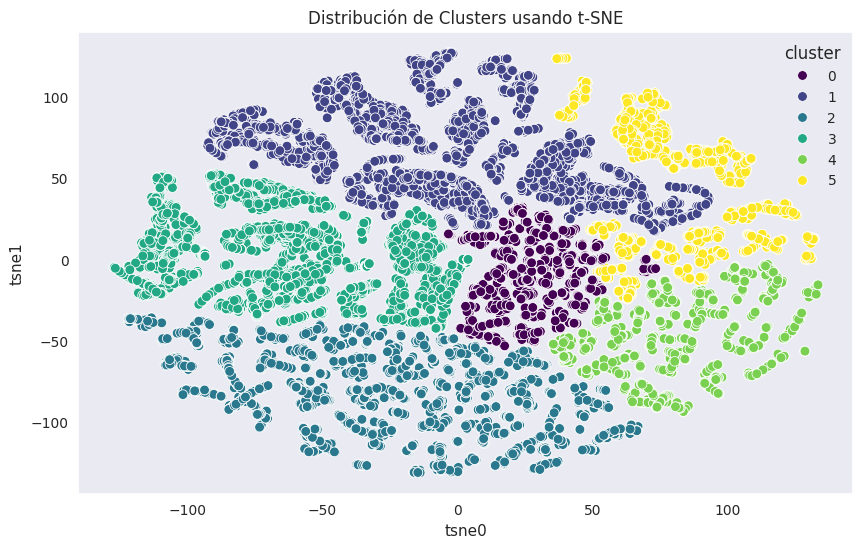

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="tsne0", y="tsne1", hue="cluster", data=tsne_df, palette="viridis")
plt.title("Distribución de Clusters usando t-SNE")
plt.show()

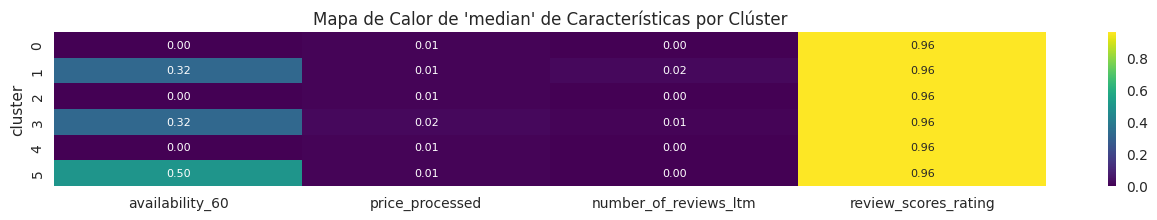

In [ ]:
dao.plot_heatmap_clusters(df[numerical_features + ["cluster"]], agg_func="median", figsize=(16, 2))

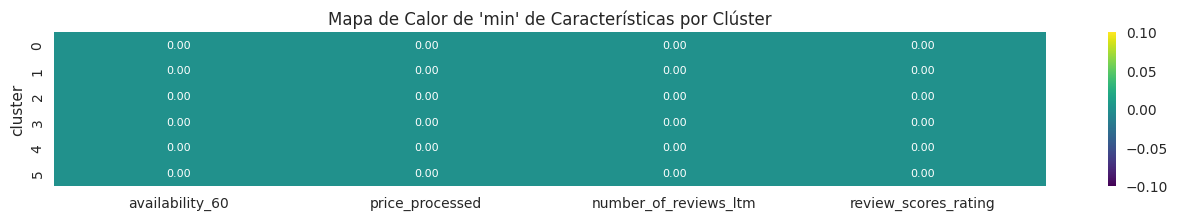

In [ ]:
dao.plot_heatmap_clusters(df[numerical_features + ["cluster"]], agg_func="min", figsize=(16, 2))

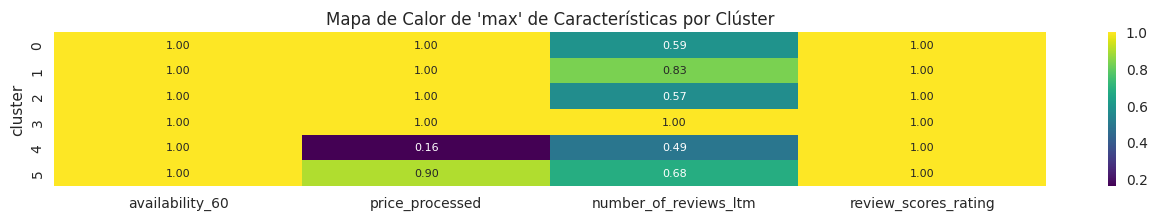

In [ ]:
dao.plot_heatmap_clusters(df[numerical_features + ["cluster"]], agg_func="max", figsize=(16, 2))

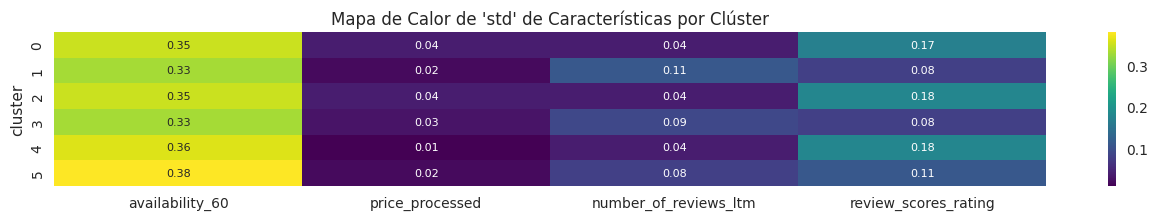

In [ ]:
dao.plot_heatmap_clusters(df[numerical_features + ["cluster"]], agg_func="std", figsize=(16, 2))

## Mapa

In [ ]:
df_mapita = pd.merge(df[["cluster"]], raw_df[["latitude", "longitude"]], on="id")
df_mapita.head(1)

cluster  latitude  longitude
id                                
2595        3  40.75356  -73.98559

In [ ]:
df_mapita.value_counts("cluster")

cluster
1    10250
3     8894
2     7876
5     3951
4     3846
0     3446
Name: count, dtype: int64

In [ ]:
colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow']

df_mapita['cluster'] = df_mapita['cluster'].astype('category')

unique_clusters = df_mapita['cluster'].unique()
color_map = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

fig = px.scatter_mapbox(
    df_mapita,
    lat='latitude',
    lon='longitude',
    color='cluster',
    size_max=1,
    zoom=9,
    mapbox_style='open-street-map',
    color_discrete_map=color_map,
    opacity=0.4
)

fig.update_layout(title='Distribución de Clusters')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1971: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
df

description host_is_superhost  \
id                                                                              
2595      Beautiful, spacious skylit studio in the heart...                 f   
3831      Enjoy 500 s.f. top floor in 1899 brownstone, w...                 f   
5121      <b>The space</b><br />HELLO EVERYONE AND THANK...                 f   
5136      We welcome you to stay in our lovely 2 br dupl...                 f   
5178      Please don’t expect the luxury here just a bas...                 f   
...                                                     ...               ...   
53662330  Must See! SPECTACULAR ONE FAMILY DUPLEX Home! ...                 f   
53662542  Must See! SPECTACULAR ONE FAMILY DUPLEX Home! ...                 f   
53662772  You can pack a lot into a minute in this centr...                 f   
53663081                                                NaN                 f   
53665099  Stunning newly remodeled apartment in Bushwick...                 f   

          host_listings_count  host_total_listings_count  \
id                                                         
2595                      8.0                        8.0   
3831                      1.0                        1.0   
5121                      1.0                        1.0   
5136                      1.0                        1.0   
5178                      1.0                        1.0   
...                       ...                        ...   
53662330                  1.0                        1.0   
53662542                  1.0                        1.0   
53662772                 10.0                       10.0   
53663081                 10.0                       10.0   
53665099                108.0                      108.0   

         host_identity_verified neighbourhood_group_cleansed  \
id                                                             
2595                          t                    Manhattan   
3831                          t                     Brooklyn   
5121                          t                     Brooklyn   
5136                          t                     Brooklyn   
5178                          f                    Manhattan   
...                         ...                          ...   
53662330                      t                        Otros   
53662542                      t                        Otros   
53662772                      t                    Manhattan   
53663081                      t                    Manhattan   
53665099                      t                     Brooklyn   

                        property_type        room_type  accommodates  \
id                                                                     
2595               Entire rental unit  Entire home/apt             1   
3831                            Otros  Entire home/apt             3   
5121      Private room in rental unit     Private room             2   
5136               Entire rental unit  Entire home/apt             4   
5178      Private room in rental unit     Private room             2   
...                               ...              ...           ...   
53662330                        Otros     Private room             2   
53662542                        Otros     Private room             2   
53662772                        Otros     Private room             2   
53663081                        Otros     Private room             2   
53665099           Entire rental unit  Entire home/apt             5   

          bedrooms  beds  minimum_nights  maximum_nights  availability_30  \
id                                                                          
2595           1.0   1.0            30.0          1125.0              3.0   
3831           1.0   3.0             1.0           730.0              3.0   
5121           1.0   1.0            30.0           730.0             30.0   
5136           2.0   2.0             5.0          1125.0  